# Imports

In [1]:
import pathlib

# Constants

In [2]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

In [3]:
# https://rstudio-pubs-static.s3.amazonaws.com/120883_c8123ff272164b2a94be097a6237150b.html
YELP_DATA_DIR = DATA_DIR / 'yelp' / 'v6' / 'yelp_dataset_challenge_academic_dataset'

# Example 4-1

Loading and cleaning the Yelp reviews dataset in Python

In [4]:
import json
import pandas as pd

In [5]:
# Load Yelp Business data
with open(YELP_DATA_DIR / 'yelp_academic_dataset_business.json') as biz_f:
    biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])

In [6]:
%%time
# Load Yelp Reviews data (~6 GB RAM, SSD)
with open(YELP_DATA_DIR / 'yelp_academic_dataset_review.json') as review_file:
    review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])

CPU times: user 20.5 s, sys: 2.49 s, total: 23 s
Wall time: 27 s


In [7]:
biz_df.shape, review_df.shape

((61184, 15), (1569264, 8))

In [8]:
# Pull out only Nightlife and Restaurants businesses
two_biz = biz_df[biz_df['categories'].map(lambda cs: ('Nightlife' in cs 
                                                      or 'Restaurants' in cs))]

In [9]:
two_biz.shape

(24187, 15)

In [10]:
# Join with the reviews to get all reviews on the two types of business
twobiz_reviews = two_biz.merge(review_df, on='business_id', how='inner')

In [11]:
twobiz_reviews.shape

(1061863, 22)

In [12]:
# Trim away the features we won't use
twobiz_reviews = twobiz_reviews[['business_id', 
                                 'name', 
                                 'stars_y', 
                                 'text', 
                                 'categories']]

In [13]:
# Create the target column--True for Nightlife businesses, and False otherwise
twobiz_reviews['target'] = twobiz_reviews['categories'].map(lambda cs: 'Nightlife' in cs)

# Example 4-2

Creating a balanced classification dataset

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Now pull out each class of reviews separately, 
# so we can create class-balanced samples for training
nightlife = twobiz_reviews[twobiz_reviews['categories'].map(lambda cs: 'Nightlife' in cs)]
restaurants = twobiz_reviews[twobiz_reviews['categories'].map(lambda cs: 'Restaurants' in cs)]

In [16]:
nightlife.shape, restaurants.shape

((210028, 6), (990627, 6))

In [17]:
nightlife_subset = nightlife.sample(frac=0.1, random_state=123)
restaurant_subset = restaurants.sample(frac=0.021, random_state=123)

In [18]:
nightlife_subset.shape, restaurant_subset.shape

((21003, 6), (20803, 6))

In [19]:
combined = pd.concat([nightlife_subset, restaurant_subset])

In [20]:
# Split into training and test data sets
training_data, test_data = train_test_split(combined, 
                                            train_size=0.7, 
                                            random_state=123)

In [21]:
training_data.shape, test_data.shape

((29264, 6), (12542, 6))

# Example 4-3

Transform features

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (normalize,
                                   FunctionTransformer) 
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfVectorizer)

In [23]:
X_train, y_train = training_data['text'], training_data['target']
X_test, y_test = test_data['text'], test_data['target']

In [24]:
# Represent the review text as a bag-of-words 
bow_transform = Pipeline([
    ('count_vectorizer', CountVectorizer())
])

X_tr_bow = bow_transform.fit_transform(X_train)
X_te_bow = bow_transform.transform(X_test)

In [25]:
len(bow_transform['count_vectorizer'].vocabulary_)

46924

In [26]:
# Create the tf-idf representation
tfidf_trfm = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(norm=None)),
])

X_tr_tfidf = tfidf_trfm.fit_transform(X_train)
X_te_tfidf = tfidf_trfm.transform(X_test)

In [27]:
# Just for kicks, l2-normalize the bag-of-words representation
l2_trfm = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('l2_normalizer', FunctionTransformer(normalize, kw_args={'axis': 0}))
])

X_tr_l2 = l2_trfm.fit_transform(X_train)
X_te_l2 = l2_trfm.transform(X_test)

# Example 4-4

Training logistic regression classifiers with default parameters

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
def simple_logistic_classify(X_train, y_train, 
                             X_test, y_test, 
                             description, 
                             C=1.0, max_iter=1000):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=C, max_iter=max_iter).fit(X_train, y_train)
    s = m.score(X_test, y_test)
    print('Test score with', description, 'features:', s)
    return m

In [30]:
m1 = simple_logistic_classify(X_tr_bow, y_train, X_te_bow, y_test, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_train, X_te_l2, y_test, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_train, X_te_tfidf, y_test, 'tf-idf')

Test score with bow features: 0.7758730664965715
Test score with l2-normalized features: 0.7635145909743263
Test score with tf-idf features: 0.7431031733375857


# Example 4-5

Tuning logistic regression hyperparameters with grid search

In [31]:
from sklearn.model_selection import (GridSearchCV, 
                                     StratifiedKFold)

In [32]:
# Specify a search grid, then do a 5-fold grid search for each of the feature sets
param_grid_ = {
    'lr_clf__C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2],
    'lr_clf__max_iter': [1000]
}

In [33]:
# Specify a cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
# Tune classifier for bag-of-words representation
bow_pipeline = Pipeline([
    *bow_transform.steps, 
    ('lr_clf', LogisticRegression())
])

bow_search = GridSearchCV(bow_pipeline, param_grid=param_grid_, cv=cv, n_jobs=-1)
bow_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('count_vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                      

In [35]:
bow_search.best_score_

0.7833515046644616

In [36]:
# Tune classifier for L2-normalized word vector
l2_pipeline = Pipeline([
    *l2_trfm.steps, 
    ('lr_clf', LogisticRegression())
])

l2_search = GridSearchCV(l2_pipeline, param_grid=param_grid_, cv=cv, n_jobs=-1)
l2_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('count_vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                      

In [37]:
l2_search.best_score_

0.7818480080262161

In [38]:
# Tune classifier for tf-idf
tfidf_pipeline = Pipeline([
    *tfidf_trfm.steps, 
    ('lr_clf', LogisticRegression())
])

tfidf_search = GridSearchCV(tfidf_pipeline, param_grid=param_grid_, cv=cv, n_jobs=-1)
tfidf_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf_vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                    

In [39]:
tfidf_search.best_score_

0.7888873551475726

In [40]:
bow_search.best_params_

{'lr_clf__C': 0.1, 'lr_clf__max_iter': 1000}

In [41]:
l2_search.best_params_

{'lr_clf__C': 10.0, 'lr_clf__max_iter': 1000}

In [42]:
tfidf_search.best_params_

{'lr_clf__C': 0.001, 'lr_clf__max_iter': 1000}

In [43]:
bow_search.cv_results_

{'mean_fit_time': array([ 3.74814363,  5.1213686 ,  8.49607949, 15.92795835, 19.49074154,
        18.34213676]),
 'std_fit_time': array([0.84572393, 0.81766023, 0.56470355, 0.7124682 , 0.3142459 ,
        0.83760014]),
 'mean_score_time': array([0.90753474, 1.12630734, 0.84838696, 0.80572805, 0.81887422,
        0.7933979 ]),
 'std_score_time': array([0.12782219, 0.19299971, 0.06055087, 0.02596226, 0.05071053,
        0.06319877]),
 'param_lr_clf__C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lr_clf__max_iter': masked_array(data=[1000, 1000, 1000, 1000, 1000, 1000],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lr_clf__C': 1e-05, 'lr_clf__max_iter': 1000},
  {'lr_clf__C': 0.001, 'lr_clf__max_iter': 1000},
  {'lr_clf__C': 0.1, 'lr_clf__max_iter': 1000},
  {'lr_clf__C': 

In [44]:
search_results = pd.DataFrame(
    data={'bow': bow_search.cv_results_['mean_test_score'],
          'l2': l2_search.cv_results_['mean_test_score'],
          'tfidf': tfidf_search.cv_results_['mean_test_score']},
    index=param_grid_['lr_clf__C']
)
search_results

,bow,l2,tfidf
0.00001,0.575724,0.575724,0.654354
0.00100,0.747095,0.575724,0.788887
0.10000,0.783352,0.645298,0.761755
1.00000,0.773715,0.774194,0.739065
10.00000,0.754306,0.781848,0.721808
100.00000,0.736605,0.761755,0.711899


In [45]:
# Our usual matplotlib incantations. 
# Seaborn is used here to make the plot pretty.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

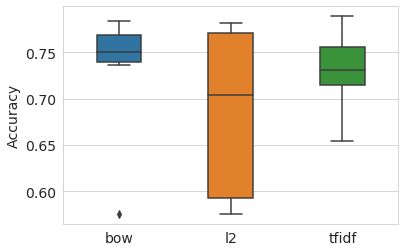

In [46]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)

# Example 4-6

Final training and testing step to compare the different feature sets

In [47]:
m1 = simple_logistic_classify(X_tr_bow, y_train, X_te_bow, y_test, 'bow', 
                              C=bow_search.best_params_['lr_clf__C'])
m2 = simple_logistic_classify(X_tr_l2, y_train, X_te_l2, y_test, 'l2-normalized', 
                              C=l2_search.best_params_['lr_clf__C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_train, X_te_tfidf, y_test, 'tf-idf', 
                              C=tfidf_search.best_params_['lr_clf__C'])

Test score with bow features: 0.7836868123106363
Test score with l2-normalized features: 0.7801785999043215
Test score with tf-idf features: 0.7871152926168076
